In [1]:
import sys; sys.path.append('../3rdparty/ElasticRods/python')

import elastic_rods, elastic_knots
from linkage_vis import LinkageViewer as Viewer
import numpy as np, matplotlib.pyplot as plt, matplotlib, os, json
from copy import copy

from helpers import *

%load_ext autoreload
%autoreload 2

In [2]:
# Download the sample dataset (equilibrium states of knots with up to 9 crossings)
# The same data can also be downloaded manually from 
# https://drive.google.com/file/d/1mwGCbWD8-Ftku5eLRwOAuvM-NGCqdXfg/
root_dir = '../data/'
data_dir = 'L400-r0.2-UpTo9Crossings'

zip_file = data_dir + '.zip'
download_data(
    gdrive_id='1mwGCbWD8-Ftku5eLRwOAuvM-NGCqdXfg',
    output_dir=root_dir,
    zip_file=zip_file
)

Directory ../data/L400-r0.2-UpTo9Crossings already exists


# Clustering

In [3]:
# Load the equilibrium states of a given knot type
knot_type = '6_2'   # <----- select a knot type

data_path = root_dir + '{}/'.format(data_dir)
rod_radius = 0.2

knot_data_path = data_path + '{}/'.format(knot_type)
objs = [f for f in sorted_nicely(os.listdir(knot_data_path)) if f.endswith('.obj')]
n = len(objs)
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])
rods = []
for obj in objs:
    pts = read_nodes_from_file(knot_data_path + obj)
    pts_aligned = align_point_cloud_principal_components_to_axes(pts)  # align to coordinate axes to facilitate visualization
    pr = define_periodic_rod(pts_aligned, material, minimize_twist=True)
    rods.append(pr)

In [4]:
# Visulize the equilibria
rod_list = build_regular_grid(rods)

view = Viewer(rod_list, width=1024, height=640)
color_rods(view, rod_list, color_metric='curvature')
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

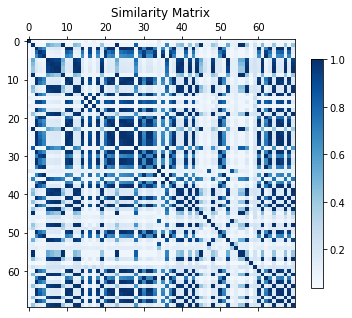

In [5]:
# Compute the similarity matrix
M = compute_similarity_matrix(rods)

fig, ax = plt.subplots(figsize=(6, 6))
matshow_data = ax.matshow(M, cmap='Blues')
fig.colorbar(matshow_data, ax=ax, location='right', shrink=0.7)
ax.set_title('Similarity Matrix')
plt.show()

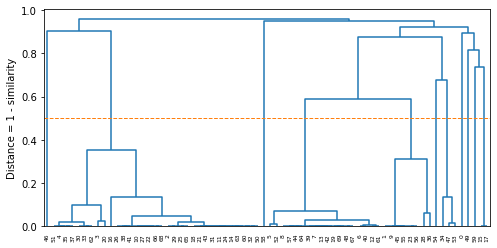

11 clusters detected with cutting threshold = 0.5


In [6]:
# Compute the clusters' hierarchy (dendrogram) using a default cutoff similarity threshold at 0.5
eq_clusters, Z, cuts, cut_thresh, dn = hierarchical_clustering_from_similarity_matrix(M, cut_thresh=0.5)
print("{} clusters detected with cutting threshold = 0.5".format(len(eq_clusters)))

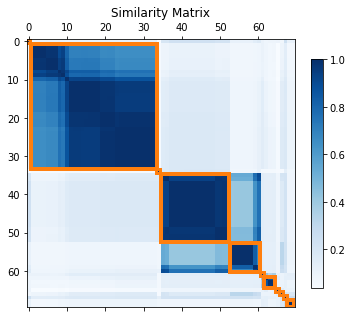

In [7]:
# Permute similarity matrix's rows to display clusters as diagonal blocks
sorted_leaves = dn['leaves']

P = np.zeros_like(M)
for i in range(n):
    P[i, sorted_leaves[i]] = 1.0
M_dendro = P @ M @ P.T

# Plot permute similarity matrix
fig, ax = plt.subplots(figsize=(6, 6))
matshow_data = ax.matshow(M_dendro, cmap='Blues')
fig.colorbar(matshow_data, ax=ax, location='right', shrink=0.7)
ax.set_title('Similarity Matrix')

# Plot squares around blocks representing clusters
n_clust = len(eq_clusters)
i_top_left = 0
for ci in range(n_clust):
    ci_size = len(eq_clusters[ci])
    i_bott_right = i_top_left + ci_size - 1

    # Plot squares
    m = i_top_left - 0.4
    L = i_bott_right - i_top_left + 0.8
    color = 'C1'
    linewidth = 4
    rectangle = plt.Rectangle([m, m], L, L, fc='none', ec=color, linewidth=linewidth)
    ax.add_patch(rectangle)
    i_top_left += ci_size

plt.show()

<a id='sec:interact'></a>
### Interactively select the best cutting threshold

In [8]:
import ipywidgets as widgets
from ipywidgets import Layout
%matplotlib inline

Select the desired cutting threshold using the slider in the next cell below. 

Once the orange squares in the similarity matrix well approximate the underlying blue blocks, move to the next cells to compute the corresponding clusters.

(For example, for the demo `6_2` knot cutting the dendrogram at ~0.71 gives the best clustering results, as can be verified by visually inspecting the clusters in the [next section](#sec:vis))

In [9]:
# Compute mid cuts to plot horizontal threshold in an unambiguous way
mid_cuts = np.zeros_like(cuts)
mid_cuts[1::] = (cuts + np.roll(cuts, 1))[1::] / 2
mid_cuts[-1] = 1.0

# Set the initial cutting threshold to the minimum value (atomic clusters)
cut_thresh = 0  
user_cut = cut_thresh

@widgets.interact(
    M=widgets.fixed(M_dendro),
    cut_thresh=widgets.SelectionSlider(
        value=cut_thresh, 
        description='Cut', 
        options=mid_cuts, 
        style={'description_width': 'initial'},
        layout=Layout(width='900px')
    )
)
def tune_clustering(M, cut_thresh=cut_thresh):
    global user_cut
    user_cut = plot_dendrogram_and_clusters(M, cut_thresh)

interactive(children=(SelectionSlider(description='Cut', layout=Layout(width='900px'), options=(0.0, 5.7483073…

In [10]:
# Compute clusters using the user-defined cut
if user_cut == 0:
    raise ValueError('Please select a cutting threshold > 0 in the previous cell.')

eq_clusters = get_clusters_from_cut_tree(Z, user_cut, sorted_leaves)
print("{} clusters detected with cutting threshold = {}".format(len(eq_clusters), user_cut))

ValueError: Please select a cutting threshold > 0 in the previous cell.

<a id='sec:vis'></a>
### Visualize the clusters corresponding to the selected cutting threshold

In [11]:
# Visualise clustered equilibrium types with color coded curvature 

rod_list = build_clustered_grid(rods, eq_clusters)

view_clustered = Viewer(rod_list, width=1024, height=640)
color_rods(view_clustered, rod_list, color_metric='curvature')
view_clustered.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …